In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import os
from sklearn.metrics import f1_score
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from datetime import datetime
from xgboost import XGBClassifier
import seaborn as sns


C:\Users\omore\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Путь к директории с данными

data_dir = '../00_data/track_1/'
extra_data_dir =  '../00_data/1_track_extra_train/'
sumbit_dir = '../02_submits/'
preprocessed_dir = '../03_preprocessed_data/'

# Метео
mc = pd.read_csv(data_dir + 'meteo_coord.csv')
mld = pd.read_csv(data_dir + 'meteo_1day.csv')
mlm = pd.read_csv(data_dir + 'meteo_1month.csv')
#m3h = pd.read_csv(data_dir + 'meteo_3hours.csv')
rhv = pd.read_csv(data_dir + 'reference_horiz_visib.csv')
main_df = pd.read_csv(data_dir + 'train.csv')
test = pd.read_csv(data_dir + 'test.csv')

# Гидро
hc = pd.read_csv(data_dir + 'hydro_coord.csv')
hld = pd.read_csv(data_dir + 'hydro_1day.csv',
                   parse_dates=['date'])
h1d_extra = pd.read_csv(extra_data_dir + 'hydro_1day.csv',
                   parse_dates=['date'])

hld = pd.concat([hld, h1d_extra])
rwc = pd.read_csv(data_dir + 'reference_water_codes.csv')
# даные реанализа сгенерированные Addidional_data.ipynb
all_pressure_data_level_1000 = pd.read_pickle(preprocessed_dir + 'all_pressure_data_level_1000.pkl')

Проранжируем станции по течению реки. Для каждой станции найдем станцию вверх по течению, добавим ширину реки

In [3]:
# Проранжировать станции по течению реки
# 3019 Киренск
# 3027 Витим
# 3028 Пелендуй
# 3029 КРЕСТОВСКОЕ 
# 3030 ЛЕНСК 
# 3035 ОЛЕКМИНСК 
# 3041 ПОКРОВСК 
# 3045 ЯКУТСК 
# 3230 БАТАМАЙ 
# 3050 САНГАРЫ 

station_id_ordered = [3019, 3027, 3028, 3029, 3030, 3035, 3041, 3045,  3230, 3050]
station_id_rank = range(0, len(station_id_ordered))
station_id_rank = dict(zip(station_id_ordered, station_id_rank))
previous_station = [-1] + station_id_ordered[:-1]
previous_station = dict(zip(station_id_ordered, previous_station))
station_width = [412, 538, 654, 832, 1000, 2070, 4100, 7390, 9000, 5370]
station_width =  dict(zip(station_id_ordered, station_width))

Из данных реанализа удалим неиспользованные переменные и неиспользуемые станции

In [4]:
all_pressure_data_level_1000['station_id'] = all_pressure_data_level_1000['station_id'].astype(int)
all_pressure_data_level_1000 = all_pressure_data_level_1000.reset_index()
all_pressure_data_level_1000 = all_pressure_data_level_1000.drop(['lat', 'lon'], axis = 1)
all_pressure_data_level_1000['date']= all_pressure_data_level_1000['time'].dt.date.astype(str)
all_pressure_data_level_1000 = all_pressure_data_level_1000[all_pressure_data_level_1000['station_id'].isin(station_id_ordered)]

In [5]:
# calculate_height_difference
# distance_from_source - расстояние от истока
# z_null - высотная отметка нуля графика на гидропосте
def calculate_height_difference(dataframe_with_stations):
    dataframe_with_stations=dataframe_with_stations.sort_values(by = 'distance_from_source')
    dataframe_with_stations['height_difference'] = dataframe_with_stations['z_null'] - dataframe_with_stations['z_null'].shift(1) 
    dataframe_with_stations['distance_to_previous'] = dataframe_with_stations['distance_from_source'] - dataframe_with_stations['distance_from_source'].shift(1)
    dataframe_with_stations['height_diff_by_dist'] = dataframe_with_stations['height_difference']/dataframe_with_stations['distance_to_previous']
    dataframe_with_stations.fillna(0, inplace = True)
    return dataframe_with_stations

# Гидрологические данные

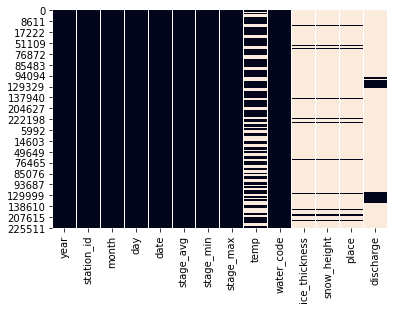

In [6]:
hld = hld[hld['station_id'].isin(station_id_ordered)]
sns.heatmap(hld.isnull(), cbar=False)

В летние месяцы заполнить толщину льда и высоту снена нулем. В остальные дни сделать интерполяцию по дате для каждой станции.

In [7]:
months_with_ice = hld.loc[ hld['ice_thickness'] > 0, 'month'].unique()
hld.loc[~(hld['month'].isin(months_with_ice)), 'ice_thickness'] = 0
hld.loc[~(hld['month'].isin(months_with_ice)), 'snow_height'] = 0
hld = hld.sort_values(['station_id', 'year', 'day'])
hld[['ice_thickness', 'snow_height']] = hld.\
    groupby('station_id')['ice_thickness',  'snow_height'].\
    apply(lambda group: group.interpolate(method='index'))

C:\Users\omore\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [8]:
hld[['ice_thickness', 'snow_height']] = hld[['ice_thickness', 'snow_height']].fillna(method='bfill', limit=20)

Пропущенную температуру воды заполним нулем

In [9]:
hld['temp'] = hld['temp'].fillna(0)

Place заполнить нулем в летние месяцы и паддингом назад в остальные

In [10]:
hld.loc[~(hld['month'].isin(months_with_ice)), 'place'] = 0
hld['place'] = hld['place'].fillna(method='bfill', limit=20)

In [11]:
hld = hld.drop(['discharge'], axis = 1)

# Метеорологические данные

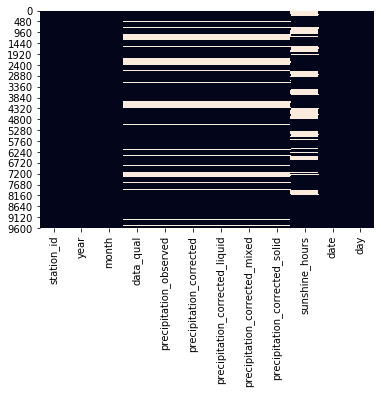

In [12]:
mlm = mlm.sort_values(['station_id', 'year', 'month'])
sns.heatmap(mlm.isnull(), cbar=False)

 Заполним пропуски интерполяцией по времени для каждой станции

In [13]:
mlm = mlm.sort_values(['station_id', 'year', 'month'])
num_cols = ['precipitation_observed',
            'precipitation_corrected', 
            'precipitation_corrected_liquid',
           'precipitation_corrected_mixed',
           'precipitation_corrected_solid',
           'sunshine_hours']
mlm[num_cols] = mlm[num_cols + ['station_id']].groupby('station_id').\
    apply(lambda group: group.interpolate(method='index')).drop('station_id', axis = 1)


Остальные пропуски заполним паддингом назад

In [14]:
mlm = mlm.fillna(method='bfill', limit=20)

Соединим train и test, чтобы фичи генерировались и на тесте тоже

In [15]:
main_df = pd.concat([main_df, test])
main_df['is_test'] = main_df['ice_jam'].isnull()
main_df['station_rank'] = main_df['station_id']
main_df = main_df.replace({"station_rank": station_id_rank})
main_df['station_width'] = main_df['station_id']
main_df = main_df.replace({'station_width': station_width})
main_df['previous_station'] = main_df['station_id']
main_df = main_df.replace({"previous_station": previous_station})
main_df['previous_station'] = main_df['previous_station'].astype(int)

## Сгенерируем признаки из labels за предыдущие года

### Затор в прошлом году в тот же день

In [16]:
main_df['previous_year'] = main_df['year'] - 1
X = main_df.merge(
        main_df[['year', 'day', 'station_id','ice_jam']], 
        how = 'left', 
        left_on = ['previous_year', 'day', 'station_id'],
        right_on = ['year', 'day', 'station_id'])\
            .drop(['year_y'], axis =1)\
            .rename(columns={
                'year_x':'year', 
                'ice_jam_x':'ice_jam',
                'ice_jam_y':'ice_jam_same_day_last_year',             
                'previous_station_x':'previous_station',
                'station_rank_x': 'station_rank',
                'previous_year_x': 'previous_year',
                'is_test_x':'is_test'})

main_df = main_df.drop('previous_year', axis = 1)
X.head()

,year,station_id,day,ice_jam,is_test,station_rank,station_width,previous_station,previous_year,ice_jam_same_day_last_year
0,2000,3019,1,0.0,False,0,412,-1,1999,0.0
1,2000,3019,2,0.0,False,0,412,-1,1999,0.0
2,2000,3019,3,0.0,False,0,412,-1,1999,0.0
3,2000,3019,4,0.0,False,0,412,-1,1999,0.0
4,2000,3019,5,0.0,False,0,412,-1,1999,0.0


### Затор в прошлом году в тот же день на предыдущей станции

In [17]:
X = X.merge(main_df[['year', 'day', 'station_id', 'ice_jam']], 
            how = 'left', 
            left_on = ['previous_year', 'day', 'previous_station'],
            right_on = ['year', 'day', 'station_id'])\
    .drop(['year_y', 'station_id_y'], axis =1)\
    .rename(columns={'year_x':'year',
                 'station_id_x':'station_id',
                 'ice_jam_x':'ice_jam',
                 'ice_jam_y':'ice_jam_same_day_last_year_prev_stat'})

In [18]:
X = X.fillna(0)

### Затор в позапрошлом году в тот же день

In [19]:
X['preprevious_year'] = X['year'] - 2
X = X.merge(main_df[['year', 'day', 'station_id', 'ice_jam']],
              how = 'left', 
              left_on = ['preprevious_year', 'day', 'station_id'],
              right_on = ['year', 'day', 'station_id']
             )\
    .drop(['preprevious_year', 'year_y'], axis = 1)\
    .rename(columns={'year_x':'year', 
                     'ice_jam_x':'ice_jam',
                     'ice_jam_y':'ice_jam_same_day_prelast_year'})

### Индикатор - есть ли данные по заторам за прошлый год

In [20]:
X['is_last_year_missing'] = X['ice_jam_same_day_last_year'].isnull()
X['is_prelast_year_missing'] = X['ice_jam_same_day_prelast_year'].isnull()
X = X.fillna(0)
X.shape

(15183, 14)

### Количество заторов в прошлом году

In [21]:
X[['n_jams_last_year','n_jams_prelast_year']] = \
    X.groupby(['year', 'station_id'])[['ice_jam_same_day_last_year', 'ice_jam_same_day_prelast_year']]\
    .transform('sum')
X.shape

(15183, 16)

### Количество заторов в прошлом году на предыдущей станции

In [22]:
X[['n_jams_last_year_prev_station']] = \
    X.groupby(['year', 'station_id'])[ 'ice_jam_same_day_last_year_prev_stat']\
    .transform('sum')

### Количество заторов в прошлом по всем годам

In [23]:
ice_jams_per_year = X.groupby(['year', 'station_id'])['ice_jam'].sum().reset_index().drop_duplicates()
ice_jams_per_year['n_jams_past'] = ice_jams_per_year.sort_values(by = 'year').\
    groupby(['station_id'])['ice_jam'].cumsum()
ice_jams_per_year['n_jams_past'] = ice_jams_per_year['n_jams_past'] - ice_jams_per_year['ice_jam']
ice_jams_per_year = ice_jams_per_year.drop('ice_jam', axis = 1)
X = X.merge(ice_jams_per_year, how = 'left', on = ['year', 'station_id'])

In [24]:
X = X.merge(ice_jams_per_year, 
            how = 'left', 
            left_on = ['year', 'previous_station'],
            right_on = ['year', 'station_id'])\
    .rename(columns={'n_jams_past_y':'n_jams_past_prev_stat',
                     'station_id_x':'station_id',
                     'n_jams_past_x':'n_jams_past'})\
    .drop('station_id_y', axis = 1)

In [25]:
# n_same_days_before: how many days are available in the past for a given date
X['n_same_days_before'] = X[['year', 'day', 'station_id']] \
    .sort_values(by = ['year', 'day']) \
    .groupby(['station_id', 'day']) \
    .cumcount()
X['n_ice_jams_same_days_before'] = X[['year', 'day', 'station_id', 'ice_jam']] \
    .sort_values(by = ['year', 'day']) \
    .groupby(['station_id', 'day'])['ice_jam'] \
    .cumsum()
X['n_ice_jams_same_days_before'] = X['n_ice_jams_same_days_before'] - X['ice_jam']
X['n_ice_jams_same_days_before_ratio'] = X['n_ice_jams_same_days_before']/X['n_same_days_before']
X = X.fillna(0)

## Разбиение по годам

In [26]:
# Суммарное количество заторов в году
jams_by_year = main_df.groupby('year').sum()['ice_jam'].to_frame().reset_index()
jams_by_year['ice_jam'].describe()

count    35.000000
mean      3.942857
std       4.014260
min       0.000000
25%       0.000000
50%       3.000000
75%       6.000000
max      16.000000
Name: ice_jam, dtype: float64

In [27]:
# Разделим на бины по квартилям
bins = [-1, 3, 5, 8, 16]
jams_by_year['ice_jam_bins'] = pd.cut(jams_by_year['ice_jam'], bins)
X_length = jams_by_year[['year', 'ice_jam']]
y_length = jams_by_year['ice_jam_bins']
y_length.value_counts()

(-1, 3]    18
(3, 5]      7
(5, 8]      6
(8, 16]     4
Name: ice_jam_bins, dtype: int64

In [28]:
# Разделим годы на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X_length, 
                                                    y_length, 
                                                    test_size=0.3,  
                                                    stratify=y_length, 
                                                    random_state=42)

### Feature description

**is_test**:  if is_test = 1 then the row belongs to the test dataset \
**ice_jam_same_day_last_year**: 1 if there were and ice jam on the same day last year \
**ice_jam_same_day_prelast_year**: 1 if there were and ice jam on the same day 2 years ago \
**is_last_year_missing**: 1 is the same day is missing last year \
**is_prelast_year_missing**: 1 is the same day is missing 2 years ago \
**n_jams_last_year**: number of jams last year at the station \
**n_jams_past**: number of jams in the past available data at the station \
**n_same_days_before**: number of same days available in the past \
**n_ice_jams_same_days_before**: number of ice jams ob the same day in the past \
**n_ice_jams_same_days_before_ratio**: n_ice_jams_same_days_before/n_ice_jams_same_days_before

### Соберем фичи из гидроданных

Эту часть кода мы взяли из baseline ноутбука

<div class="alert alert-block alert-warning">
Мы не можем использовать данные из будущего: всё, что происходит после заторного периода, относится уже к следующему году.
</div>

In [29]:
# Внесем не темпоральные данные
X = pd.merge(X, hc[['station_id', 
                                'distance_from_source', 
                                'drainage_area', 
                                'z_null']], on='station_id', how='left')
# Возьмем также данные из ежедневных наблюдений
hld.head(1)

,year,station_id,month,day,date,stage_avg,stage_min,stage_max,temp,water_code,ice_thickness,snow_height,place
4864,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,16,53.0,29.0,1.0


In [30]:
# добавим реанализ к гидро данным
hld['date']= hld['date'].astype(str)
hld = hld.merge(all_pressure_data_level_1000, on=['station_id', 'date'], how='left')

In [31]:
hld['station_id'] = hld.station_id.astype(int)
mld['station_id'] = mld['station_id'].astype(int)

In [32]:
# Подтянем ближайшую к гидростанции метеостанцию

from geopy.distance import geodesic
import re

def merge_coord(df):
    df['lat_long'] = df[['lat', 'lon']].apply(tuple, axis=1)
    return df

def stat_km(point, stat_list):
    stations_list=stat_list
    lst=[]
    if pd.isnull(point):
        lst.append(np.nan)
    else:
        for i in stations_list['lat_long']:
            x=geodesic(point, i).km
            lst.append(x)
            stations_list['dist']=pd.DataFrame(lst)
        y=stations_list['station_id'][stations_list['dist'] == stations_list['dist'].min()]
        y=y.to_string()
        y=re.sub("^[0-9]+", "", y)
        y=re.sub(" +", "", y)
        return int(y)

hc = merge_coord(hc)
mc = merge_coord(mc)
hc['closest_hydro'] = mc.lat_long.apply(lambda x: stat_km(x, mc))
mld = mld.merge(hc[['station_id', 'closest_hydro']], left_on=['station_id'], 
                right_on='closest_hydro', how='right')
mld.drop(['station_id_x', 'closest_hydro', 'date'], axis=1, inplace=True)
mld.rename({'station_id_y': 'station_id'}, axis=1, inplace=True)

In [33]:
mlm['data_qual'] = mlm['data_qual'].fillna(10)

In [34]:
mlm['missing_sunshine_hours'] = mlm['sunshine_hours'].isnull()
mlm['sunshine_hours'] = mlm['sunshine_hours'].fillna(0)

In [35]:
hld = hld.merge(mld, on=['station_id', 'year', 'month', 'day'], how='inner')
#hld = hld.fillna(0)

Добавим разницу высот между станцией и предыдущей станцией

In [36]:
stations_df = hc[['station_id', 'distance_from_source', 'z_null']].drop_duplicates()
stations_df = calculate_height_difference(stations_df)

### Скорректируем год, в который доступно наблюдение

In [37]:
# Определим для наблюдения год, в который оно доступно

# Маска-окно между заторным периодом и концом года
# true if after jam
# false otherwise
def after_jam_window(row, local=False):
    if local:
        month = row.month_local
        day = row.date_local.day
    else:
        month = row.month
        day = row.date.day
    return (((month == 6) and (day > 3))
            or (month in [7, 8, 9, 10, 11, 12]))

# Год относительно бизнес-логики
def target_year(row, local=False):
    if local:
        year = row.year_local
    else:
        year = row.year
    if after_jam_window(row):
        return year + 1
    else:
        return year

hld['date'] = pd.to_datetime(hld['date'], format='%Y-%m-%d')
hld['target_year'] = hld.apply(target_year, axis=1)

# Календарный год и день больше не нужны
hld.drop(columns=['year', 'date', 'day'], axis=1, inplace=True)

In [38]:
# Гидро – сделаем ресэмплинг по месяцу
index = ['station_id', 'month', 'target_year']
cat_col = ['place']

hld_mean = hld.drop(cat_col, axis = 1).groupby(index).mean().add_prefix('mean_').reset_index()
hld_max = hld.drop(cat_col, axis = 1).groupby(index).max().add_prefix('max_').reset_index()
hld_min = hld.drop(cat_col, axis = 1).groupby(index).min().add_prefix('min_').reset_index()
hld_std = hld.drop(cat_col, axis = 1).groupby(index).std().add_prefix('std_').reset_index()
h1d_cat = hld[index + cat_col].groupby(index).median().add_prefix('median_').reset_index()

data_frames = [hld_mean, hld_max, hld_min, hld_std, h1d_cat]

hydro_monthly = pd.concat(data_frames, axis=1)
hydro_monthly = hydro_monthly.loc[:,~hydro_monthly.columns.duplicated()]

In [39]:
hydro_monthly['stage_inc_monthly'] = hydro_monthly['max_stage_max']/hydro_monthly['min_stage_min']

## Удалить колонки, где пропущено более 20%

In [40]:
missing_hydro_monthly = hydro_monthly.isnull()\
    .mean()\
    .reset_index()\
    .rename(columns={'index':'column', 0:'percent_missing'})
columns_to_drop = missing_hydro_monthly.loc[missing_hydro_monthly['percent_missing'] > .2, 'column'].to_list()
hydro_monthly = hydro_monthly.drop(columns_to_drop, axis = 1)

# В колонках, где пропущено менее 20%, заполнить медианными значениями за тот же период по другим станциям

In [41]:
missing_hydro_monthly = hydro_monthly.isnull()\
    .mean()\
    .reset_index()\
    .rename(columns={'index':'column', 0:'percent_missing'})
columns_to_fill = missing_hydro_monthly.loc[missing_hydro_monthly['percent_missing'] > 0, 'column'].to_list()
for feature in columns_to_fill:
    hydro_monthly[feature] = hydro_monthly.groupby(['target_year', 'month'])[feature].transform(lambda x: x.fillna(x.median()))

C:\Users\omore\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\omore\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\omore\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\omore\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\omore\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\omore\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=ke

In [42]:
def make_features(df):
    station, target_year = df.name
    result = pd.DataFrame()
    for month, mdf in df.groupby('month'):
        m_feats = mdf[df.columns[4:]].add_prefix(str(month) + '_').reset_index(drop=True)
        result = pd.concat([result, m_feats], axis=1)
    return result.reset_index(drop=True)
        
hydro_features = hydro_monthly.groupby(['station_id', 'target_year']).apply(make_features)
hydro_features = hydro_features.reset_index(level=2, drop=True).reset_index()
hydro_features.dropna(how='all', axis=1, inplace=True)

### Соберем фичи в основной датасет

<div class="alert alert-block alert-success">
Важно: merge делаем по target_year.
</div>

In [43]:
X = pd.merge(X, hydro_features, left_on=['year', 'station_id'],
                   right_on=['target_year', 'station_id'],
                   how='left').\
    drop('target_year', axis = 1)
cols = X.columns.to_list()
#main_df = main_df[cols[:3] + [cols[7]] + cols[5:7] + cols[8:] + [cols[3]]]
#main_df.dropna(how='any',inplace=True)
#main_df.head(2)

In [44]:
X = X.merge(stations_df[['station_id', 'height_diff_by_dist']], on = 'station_id', how = 'left')

In [45]:
def drop_columns_with_low_variance(dataframe, threshold):
    print('Dropped columns with variance low than {}'.format(threshold))
    cols_to_drop = dataframe.std()[dataframe.std() < threshold].index.values
    cols_to_drop = [x for x in cols_to_drop if x != 'ice_jam']
    dataframe.drop(cols_to_drop, axis=1, inplace = True)
    print(cols_to_drop)
    return dataframe

#X = drop_columns_with_low_variance(X, 0.000001)

In [46]:
def drop_highly_correlated_columns(dataframe, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataframe.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (abs(corr_matrix.iloc[i, j]) >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataframe.columns:
                    del dataframe[colname] # deleting the column from the dataset
    return dataframe

Заменить Inf на 100.

In [47]:
#X = X.drop(['station_rank_y', 'station_rank_x'], axis =1 )
#X = drop_highly_correlated_columns(X, 0.95)
X[[x for x in X.columns if 'inc'  in x]] = \
    X[[x for x in X.columns if 'inc'  in x]].replace(np.inf, 100)

In [48]:
# Разделим на трейн и тест исходя из target_year

test = X[X.year.isin(X_test.year.to_list()) & (X['is_test'] == False)].reset_index(drop=True).dropna()
train = X[X.year.isin(X_train.year.to_list())& (X['is_test'] == False)].reset_index(drop=True).dropna()


# Поделим данные на предикторы и таргет

X_train, y_train = train.drop(['ice_jam'], axis = 1), train.ice_jam
X_test, y_test = test.drop(['ice_jam'], axis = 1), test.ice_jam
unused_features = ['year', 'is_test']

X_train.to_csv(preprocessed_dir + 'X_train.csv', index = False)
X_test.to_csv(preprocessed_dir + 'X_test.csv', index = False)
y_train.to_csv(preprocessed_dir + 'y_train.csv', index = False)
y_test.to_csv(preprocessed_dir + 'y_test.csv', index = False)
X.to_csv(preprocessed_dir + 'X.csv', index = False)

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
#lsvc = SVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)

unused_features = [ 'is_test']
cat_col = ['1_max_water_code', 
           '2_max_water_code',
           '6_max_water_code',
           '7_max_water_code',
           '9_max_water_code',
           '10_max_water_code',
           '11_max_water_code',
           '12_max_water_code',
           '1_min_water_code',
           '2_min_water_code',
           '6_min_water_code',
           '7_max_water_code',
           '9_min_water_code',
           '10_min_water_code',
           '11_min_water_code',
           '12_min_water_code'
          ]
unused_features = unused_features + cat_col
X_train_used = X_train.drop(cat_col, axis =1 )
selector = RFE(LogisticRegression(max_iter=5000),
               n_features_to_select=200, step=10).fit(X_train_used, y_train)
